In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [4]:
c = 'D:/dataset/iwp2/COVID-19_Radiography_Dataset/COVID/images'
n = 'D:/dataset/iwp2/COVID-19_Radiography_Dataset/Normal/images'
p = 'D:/dataset/iwp2/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [5]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 5000) + os.listdir(p)

In [6]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [7]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df.head()

,filename,category
0,D:/dataset/iwp2/COVID-19_Radiography_Dataset/C...,2
1,D:/dataset/iwp2/COVID-19_Radiography_Dataset/C...,2
2,D:/dataset/iwp2/COVID-19_Radiography_Dataset/C...,2
3,D:/dataset/iwp2/COVID-19_Radiography_Dataset/C...,2
4,D:/dataset/iwp2/COVID-19_Radiography_Dataset/C...,2


In [9]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [10]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [11]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 7968 validated image filenames belonging to 3 classes.


In [13]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 997 validated image filenames belonging to 3 classes.


In [14]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

58900480/58889256 [==============================] - 109s 2us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
epochs = 50
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/50
532/532 [==============================] - 156s 293ms/step - loss: 0.5009 - accuracy: 0.7971 - val_loss: 0.3782 - val_accuracy: 0.8536
Epoch 2/50
532/532 [==============================] - 66s 124ms/step - loss: 0.4163 - accuracy: 0.8304 - val_loss: 0.3138 - val_accuracy: 0.8867
Epoch 3/50
532/532 [==============================] - 69s 129ms/step - loss: 0.3620 - accuracy: 0.8519 - val_loss: 0.2790 - val_accuracy: 0.8947
Epoch 4/50
532/532 [==============================] - 65s 123ms/step - loss: 0.3448 - accuracy: 0.8618 - val_loss: 0.2658 - val_accuracy: 0.9017
Epoch 5/50
532/532 [==============================] - 65s 122ms/step - loss: 0.3206 - accuracy: 0.8656 - val_loss: 0.2689 - val_accuracy: 0.9017
Epoch 6/50
532/532 [==============================] - 65s 122ms/step - loss: 0.3020 - accuracy: 0.8788 - val_loss: 0.2403 - val_accuracy: 0.9127
Epoch 7/50
532/532 [==============================] - 65s 122ms/step - loss: 0.2923 - accuracy: 0.8855 - val_loss: 0.2755 - val_a

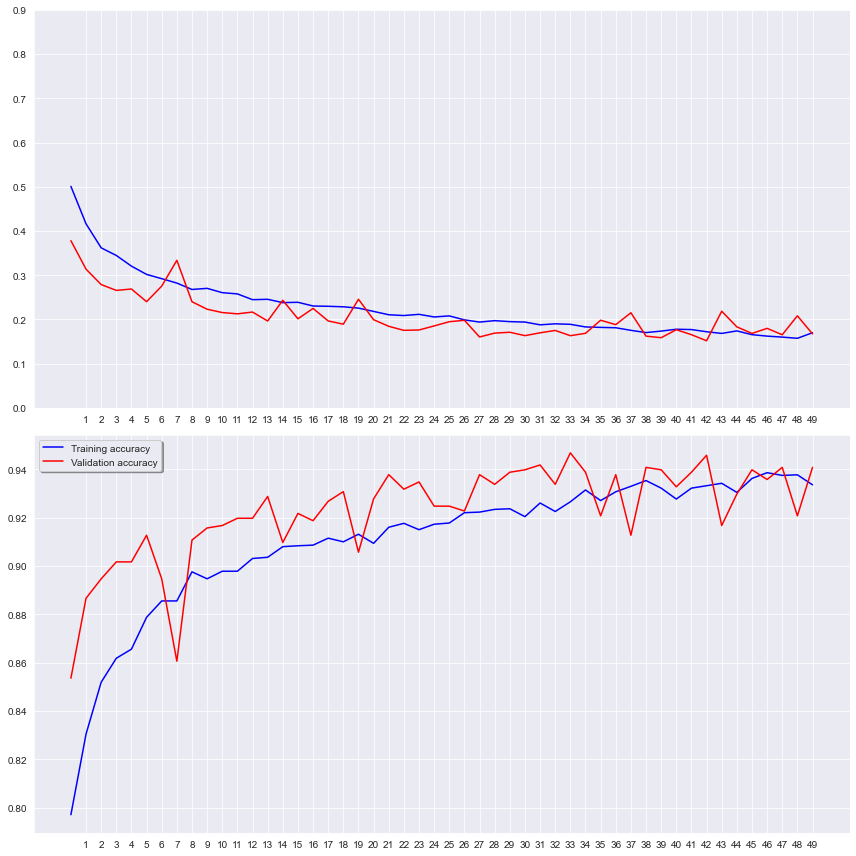

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()